In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize

meanEstCorr1, stdstCorr1:  0.6632129029325979 0.05057771862129714
meanEstCorr2, stdstCorr2:  0.7021820754988533 0.05257070117716489
RMSE1:  0.06254115550244954
RMSE2:  0.052615967878025985


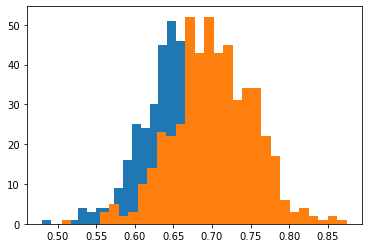

In [2]:
muX = 1
muY = 1
sigmaX = 1
sigmaY = 1
corr = .7
sigmaE = 1
m = 4
n = 200
trials = 500
covM = [[sigmaX**2, corr*sigmaX*sigmaY], [corr*sigmaX*sigmaY, sigmaY**2]]
corrs = np.zeros(trials)
paramsMLE = np.zeros((trials,4))
corrsMLE = np.zeros(trials)
doMLE = True

if doMLE: # defines functions to evaluate log likelihood
    # If J is matrix of all 1's and I is the identity matrix, then the cov of (W1,...,Wm,Z1,...,Zm) is
    # Sigma = [[vx * J; vxy * J ] [vxy * J; vy * J]] + ve I, 
    # where vx = var(X), vxv = Cov(X,Y), vy = Var(Y), ve + Var(e)
    # Inverse of Sigma is given by [[a * J; b * J], [b * J; c * J]] + 1/ve * I 
    # for a,b,c defined below (I think, have to double check)
    def D(vx, vy, vxy):
        return vx * vy - vxy**2

    def Del(vx, vy, vxy, ve):
        return ve**2 + m * ve * (vx + vy) + m**2 * D(vx, vy, vxy)

    def a(vx, vy, vxy, ve):
        return - ( (m * D(vx, vy, vxy) + vx * ve)
                / (ve*Del(vx, vy, vxy, ve)) )

    def c(vx, vy, vxy, ve):
        return - ( (m * D(vx, vy, vxy) + vy * ve)
                / (ve*Del(vx, vy, vxy, ve)) )

    def b(vx, vy, vxy, ve):
        return - vxy / Del(vx, vy, vxy, ve)


    def logDetSigma(vx, vy, vxy, ve):
        # this is log det (Sigma) 
        abc = vx*vy*m + ve*(vx+vy) - m* vxy**2
        return np.log(1 + abc * m / ve**2) + 2 * m * np.log(ve)

    def negLogLik(params, wVar_, zVar_, wCrossCov_, zCrossCov_, wzCrossCov_):
        vx,vy,vxy,ve = params
        # this is n/2 logDetSigma + (w - wBar,z - zBar)^T Sigma^{-1} (w-wBar,z-zBar)
        return (
            n/2*logDetSigma(vx, vy, vxy, ve)
            + a(vx, vy, vxy, ve) * wCrossCov_
            + c(vx, vy, vxy, ve) * zCrossCov_
            + wVar_ / ve
            + zVar_ / ve
            + 2 * b(vx, vy, vxy, ve) * wzCrossCov_
        )
    


for trial in range(trials):
    XY = np.random.multivariate_normal([muX,muY], covM, size = n)
    X, Y = XY[:,0], XY[:,1]
    E = np.random.normal(loc= 0, scale=sigmaE, size = (n,m,2))

    W = E[:,:,0] + X.reshape(n,1)
    Z = E[:,:,1] + Y.reshape(n,1)

    # First compute a naive correlation estimate
    wMeans = np.mean(W,axis=1)
    wVarMean = np.var(wMeans) # take vars of means
    zMeans = np.mean(Z,axis=1)
    zVarMean = np.var(zMeans)
    eVarW = np.mean(np.var(W,axis=1)) # take means of vars
    eVarZ = np.mean(np.var(Z,axis=1))
    eVar = (eVarW + eVarZ) / 2 # good estimate of variance of noise

    wzCov = np.cov(wMeans,zMeans)[0,1] # an estimate of covariance of W and Z
    # we expect wVarMean to be approx Var(X) + Var(e)/m**2, so we can subtract this off

    corrEst = wzCov / np.sqrt((wVarMean - eVar/m) * (zVarMean - eVar/m)) # this is the corrected version
    corrs[trial] = corrEst

    # MLE approach
    if doMLE:
        wMean = np.mean(W) # these are the MLE for means, independent of covariance
        zMean = np.mean(Z)
        wN = W - wMean
        zN = Z - zMean
        wVar = np.sum(wN**2)
        zVar = np.sum(zN**2)
        wCrossCov = np.sum(np.sum(wN,axis=1)**2)
        zCrossCov = np.sum(np.sum(zN,axis=1)**2)
        wzCrossCov = np.dot(np.sum(wN,axis=1),np.sum(zN,axis=1))

        #x0 = [vx0, vy0, vxy0, ve0]
        x0 = [wVarMean - eVar/m**2, zVarMean - eVar/m**2, wzCov, eVar] # initiate at naive guesses
        bnds = ((0, None), (0, None),(None,None),(0,None))
        result = scipy.optimize.minimize(negLogLik, x0, bounds = bnds, 
                                         args = (wVar, zVar, wCrossCov, zCrossCov, wzCrossCov))
        params = result.x
        paramsMLE[trial] = params
        corrsMLE[trial] = params[2] / np.sqrt(params[0] * params[1])

print("meanEstCorr1, stdstCorr1: ", np.mean(corrs), np.std(corrs))
print("meanEstCorr2, stdstCorr2: ", np.mean(corrsMLE), np.std(corrsMLE))
print("RMSE1: ", np.sqrt(np.mean((corrs - corr)**2)))
print("RMSE2: ", np.sqrt(np.mean((corrsMLE - corr)**2)))

plt.clf()
plt.hist(corrs,bins=30)
plt.hist(corrsMLE,bins=30)

plt.show()